# Analysis of Various Chess Openings Based on Outcomes of Randomly Sampled Chess Games
Collaborators: Viraj Boreda, Ishan Gopalani, Eric Huang, Ayush Sood

# Introduction
The purpose of this project is to showcase the entire data science lifecycle. We have chosen to do this using a dataset containing information about many chess games, such as the outcome of each of these games, the reason for each game's termination, the rating of each player, and more. The specific parameter we have chosen to take an interest in from this dataset is the type of opening played in each game. The goal of our project is to analyze games played with different openings, and see what we learn about which openings are more favorable to play.

Chess has been around, in some form or another, for around 1,400 years, although the game as we know it did not arise until the 16th century. Today, Chess continues to be widely popular among all demographics of people, with the World Chess Championship drawing many eyes and Chess.com hosting over 100 million chess players. As Chess maintains it's popularity, more and more people want to get into Chess as a hobby or improve their Chess skills. However, with a game that has such a rich history, the number of things to learn can be daunting. One specific skill that a good Chess player must know is how to both play and recognize different openings. But even the number of openings is no miniscule number, and so even learning that can seem like a difficult feat. Our hope is that the results of our project can shed light on the best openings, narrowing the scope of which openings newer players should focus on, if they wish to improve at the game of Chess.

Over this tutorial, we will traverse the Data Science lifecycle as follows:

1. Data Collection
2. Data Processing
3. Exploratory Analysis/Data Visualization
4. Model: Analysis, Hypothesis Testing, Machine Learning
5. Interpretation of Results

# 1. Data Collection
The dataset we used for this project was acquired from kaggle, and it contains 6.2 million games from lichess.org, a free and open-source chess server developed by a nonprofit company. Specifically, the dataset we used can be found [here](https://www.kaggle.com/datasets/arevel/chess-games).

To get this dataset, we simply directly downloaded the CSV file. However, because this dataset contains 6.2 million games, we decided to not use the full dataset, for both ease of data analysis and file size restrictions on GitHub. We decided to go about this by writing code to randomly select 20% of the dataset, and proceed with that section of the data.


First, we have to make the necessary imports. These are not specific to the Data Collection section of the project, but are the libraries that we use throughout the project. 

In [3]:
import csv
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import stockfish as sf
import os
import chess
from chess import pgn
import io
from dotenv import dotenv_values

We also mount google drive here, since we are using Colab and need to do this to access the necessary files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Next, we randomly select 20% of the dataset, as described above. However, you may notice the code for this section produces two different csv files, one called games_20.csv and the other called games_25.csv. This is because initially, we were unsure of whether or not we wanted to randomly choose 20% or 25% of the dataset, so we decided to try both, and ultimately settled for the 20%.

In [ ]:
rows_20, rows_25 = [], []

with open('chess_games.csv') as infile:
    header = True
    for row in csv.reader(infile):
        if header:
            rows_20.append(row)
            rows_25.append(row)
            header = False
        else:
            x = random.randint(0, 4)
            if x == 0:
                rows_20.append(row)
            y = random.randint(0, 3)
            if y == 0:
                rows_25.append(row)

with open('games_20.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    for row in rows_20:
        writer.writerow(row)

with open('games_25.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    for row in rows_25:
        writer.writerow(row)

# 2. Data Processing

While the csv file contains a lot of useful data about the games, after using pandas to read the csv file into a dataframe, we felt that the way some of this information is represented could be improved. So, we decided to add a few columns to the dataframe. First, for context, here is the dataframe with no modifications, after just reading in the csv file.

In [2]:
file_path = 'drive/My Drive/Colab Notebooks/CMSC320/Final/games_20.csv'

In [3]:
file_path = 'games_20.csv'

In [4]:
df = pd.read_csv(file_path)
df.head()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016.06.30,22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz tournament,Shambobala,cernunnoss,1-0,2016.06.30,22:00:02,1764,1773,12.0,-12.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Nf6 4. Be2 c6 5. ...
2,Classical,DARDELU,chess4life54,0-1,2016.06.30,22:00:01,1649,1638,-13.0,11.0,C57,"Italian Game: Two Knights Defense, Traxler Cou...",900+3,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 Bc5 5. N...
3,Blitz tournament,lj1983,plmnnnn,1-0,2016.06.30,22:00:02,1963,1979,12.0,-13.0,B10,Caro-Kann Defense: Two Knights Attack,180+0,Normal,1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...
4,Blitz tournament,yoyoparker,philastro110,1-0,2016.06.30,22:00:02,1707,1739,13.0,-12.0,B01,Scandinavian Defense,300+0,Normal,1. e4 d5 2. e5 Bf5 3. d4 e6 4. Nc3 Nc6 5. Nf3 ...


The first order of business was to add a column that says whether white or black won the game in question. There is already a result column that says '1-0' if white won, '0-1' if black won, and '1/2-1/2' if the game ended in a draw, but we felt that using the values in this column every time we wanted to access the winner would be tedious and error-prone. So, we added a new column that says 'White' if white was the winner, 'Black' if black was the winner, and 'Draw' if the game ended in a draw. Below is the result.

In [5]:
df = df.assign(Winner = 'White')
df.loc[df['Result'] == '0-1', 'Winner'] = 'Black'
df.loc[df['Result'] == '1/2-1/2', 'Winner'] = 'Draw'
df.head()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,Winner
0,Classical,eisaaaa,HAMID449,1-0,2016.06.30,22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,White
1,Blitz tournament,Shambobala,cernunnoss,1-0,2016.06.30,22:00:02,1764,1773,12.0,-12.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Nf6 4. Be2 c6 5. ...,White
2,Classical,DARDELU,chess4life54,0-1,2016.06.30,22:00:01,1649,1638,-13.0,11.0,C57,"Italian Game: Two Knights Defense, Traxler Cou...",900+3,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 Bc5 5. N...,Black
3,Blitz tournament,lj1983,plmnnnn,1-0,2016.06.30,22:00:02,1963,1979,12.0,-13.0,B10,Caro-Kann Defense: Two Knights Attack,180+0,Normal,1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...,White
4,Blitz tournament,yoyoparker,philastro110,1-0,2016.06.30,22:00:02,1707,1739,13.0,-12.0,B01,Scandinavian Defense,300+0,Normal,1. e4 d5 2. e5 Bf5 3. d4 e6 4. Nc3 Nc6 5. Nf3 ...,White


Next, we wanted to add a column that contains the number of moves played in each game. We wanted this information because it would help us later on when analyzing opening efficiency.

In [6]:
df['Moves'] = df['AN']
def get_moves(pgn):
  moves = re.findall(r"\d*\.", pgn)
  last = moves[len(moves) - 1]
  return re.sub("[^0-9]", "", last)
df['Moves'] = df['Moves'].apply(get_moves)
df.head()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,Winner,Moves
0,Classical,eisaaaa,HAMID449,1-0,2016.06.30,22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,White,38
1,Blitz tournament,Shambobala,cernunnoss,1-0,2016.06.30,22:00:02,1764,1773,12.0,-12.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Nf6 4. Be2 c6 5. ...,White,43
2,Classical,DARDELU,chess4life54,0-1,2016.06.30,22:00:01,1649,1638,-13.0,11.0,C57,"Italian Game: Two Knights Defense, Traxler Cou...",900+3,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 Bc5 5. N...,Black,22
3,Blitz tournament,lj1983,plmnnnn,1-0,2016.06.30,22:00:02,1963,1979,12.0,-13.0,B10,Caro-Kann Defense: Two Knights Attack,180+0,Normal,1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...,White,21
4,Blitz tournament,yoyoparker,philastro110,1-0,2016.06.30,22:00:02,1707,1739,13.0,-12.0,B01,Scandinavian Defense,300+0,Normal,1. e4 d5 2. e5 Bf5 3. d4 e6 4. Nc3 Nc6 5. Nf3 ...,White,62


The 'Opening' column is very specific here, in that it contains the specific variation of the opening played in each game, not the general opening. This is not a bad thing, but we felt that in our analysis, we could need quick access to the general opening (not the specific variation). Therefore, we decided to make an additional column that also stores the generic opening and add it to the dataframe.

In [7]:
df['GeneralOpening'] = df['Opening']
def make_general(opening):
  if ':' in opening:
    return opening.split(':')[0]
  else:
    return opening
df['GeneralOpening'] = df['GeneralOpening'].apply(make_general)
df.head()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,Winner,Moves,General Opening
0,Classical,eisaaaa,HAMID449,1-0,2016.06.30,22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,White,38,Slav Defense
1,Blitz tournament,Shambobala,cernunnoss,1-0,2016.06.30,22:00:02,1764,1773,12.0,-12.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Nf6 4. Be2 c6 5. ...,White,43,Scandinavian Defense
2,Classical,DARDELU,chess4life54,0-1,2016.06.30,22:00:01,1649,1638,-13.0,11.0,C57,"Italian Game: Two Knights Defense, Traxler Cou...",900+3,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 Bc5 5. N...,Black,22,Italian Game
3,Blitz tournament,lj1983,plmnnnn,1-0,2016.06.30,22:00:02,1963,1979,12.0,-13.0,B10,Caro-Kann Defense: Two Knights Attack,180+0,Normal,1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...,White,21,Caro-Kann Defense
4,Blitz tournament,yoyoparker,philastro110,1-0,2016.06.30,22:00:02,1707,1739,13.0,-12.0,B01,Scandinavian Defense,300+0,Normal,1. e4 d5 2. e5 Bf5 3. d4 e6 4. Nc3 Nc6 5. Nf3 ...,White,62,Scandinavian Defense


There are some columns in the dataframe that are not relevant to our analysis. Therefore, we removed the unnecessary columns before proceeding.

In [8]:
df = df.drop('White', axis=1)
df = df.drop('Black', axis=1)
df = df.drop('UTCDate', axis = 1)
df = df.drop('UTCTime', axis = 1)
# Remove any other unnecessary columns
df.head()
df.to_csv("before_stockfish.csv")

In this next section, we used the Stockfish Python library to evaluate which player was winning at the end of the game. This is important because if someone resigned while they were winning by a large amount, for example, it would be unfair to count that resignation as a true win for the opening the opponent played. This is because the opening itself did not lead to a winning position. Instead, it was likely an outside factor such as the player who resigned having to quit the game. 

The first code block just gets the path to the Stockfish engine from a .env file, as different team members may have it stored in different file paths.

In [8]:
config = dotenv_values(".env")
stockfish_path = config.get('STOCKFISH_PATH')
stockfish = sf.Stockfish(stockfish_path, depth=10)

The next code block uses the python-chess library. The stockfish library requires board positions in the FEN notation, but our dataset has the moves in PGN notation. Therefore, they need to be converted. The function below will take in a PGN and convert it to an FEN by reading the moves in to the python-chess library, then returning the fen.

In [14]:
counter = 0
def fen_convert(moves):
    global counter
    counter += 1
    if counter % 100 == 0:
        print("finished processing {} games".format(counter))

    pgn1 = io.StringIO(moves)
    game = pgn.read_game(pgn1)
    board = game.board()
    for move in game.mainline_moves():
        board.push(move)
    return board.fen()
df['FEN'] = [fen_convert(moves) for moves in df['AN']]
df.head()

finished processing 100 games
finished processing 200 games
finished processing 300 games
finished processing 400 games
finished processing 500 games
finished processing 600 games
finished processing 700 games
finished processing 800 games
finished processing 900 games
finished processing 1000 games
finished processing 1100 games
finished processing 1200 games
finished processing 1300 games
finished processing 1400 games
finished processing 1500 games
finished processing 1600 games
finished processing 1700 games
finished processing 1800 games
finished processing 1900 games
finished processing 2000 games
finished processing 2100 games
finished processing 2200 games
finished processing 2300 games
finished processing 2400 games
finished processing 2500 games
finished processing 2600 games
finished processing 2700 games
finished processing 2800 games
finished processing 2900 games
finished processing 3000 games
finished processing 3100 games
finished processing 3200 games
finished processi

,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,Winner,Moves,General Opening,FEN
0,Classical,1-0,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,White,38,Slav Defense,3r2k1/6pp/p2P1prq/8/2p5/P1B1P2P/1P3PPQ/2RR2K1 ...
1,Blitz tournament,1-0,1764,1773,12.0,-12.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Nf6 4. Be2 c6 5. ...,White,43,Scandinavian Defense,6k1/5p1p/4p1p1/p2b4/P7/6KP/6P1/3q4 b - - 3 43
2,Classical,0-1,1649,1638,-13.0,11.0,C57,"Italian Game: Two Knights Defense, Traxler Cou...",900+3,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 Bc5 5. N...,Black,22,Italian Game,r7/p1pp2pp/1p4k1/3bp3/8/3P4/PPnB1K2/6R1 b - - ...
3,Blitz tournament,1-0,1963,1979,12.0,-13.0,B10,Caro-Kann Defense: Two Knights Attack,180+0,Normal,1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...,White,21,Caro-Kann Defense,3r2k1/p3ppb1/2p4p/2B2P2/2p1P3/2N5/PPR3P1/6K1 b...
4,Blitz tournament,1-0,1707,1739,13.0,-12.0,B01,Scandinavian Defense,300+0,Normal,1. e4 d5 2. e5 Bf5 3. d4 e6 4. Nc3 Nc6 5. Nf3 ...,White,62,Scandinavian Defense,4k3/5pP1/2p2P2/2Pp2K1/4p1P1/2P5/6b1/8 b - - 0 62


This code saves the FENs generated above to a csv file just in case, as the previous code can take over half an hour to run locally. The second code block reads from the file if necessary; otherwise, the FEN data is already in the dataframe from earlier.

In [21]:
output_file = 'fen.csv'
f = open(output_file, 'w', encoding='utf-8')
for item in df['FEN']:
    f.write(item + "\n")
f.close()

In [9]:
fen_df = pd.read_csv('fen.csv', header=None, names=['FEN'])
df = pd.concat([df, fen_df], axis=1)
df.head()

,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,Winner,Moves,General Opening,FEN
0,Classical,1-0,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,White,38,Slav Defense,3r2k1/6pp/p2P1prq/8/2p5/P1B1P2P/1P3PPQ/2RR2K1 ...
1,Blitz tournament,1-0,1764,1773,12.0,-12.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Nf6 4. Be2 c6 5. ...,White,43,Scandinavian Defense,6k1/5p1p/4p1p1/p2b4/P7/6KP/6P1/3q4 b - - 3 43
2,Classical,0-1,1649,1638,-13.0,11.0,C57,"Italian Game: Two Knights Defense, Traxler Cou...",900+3,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 Bc5 5. N...,Black,22,Italian Game,r7/p1pp2pp/1p4k1/3bp3/8/3P4/PPnB1K2/6R1 b - - ...
3,Blitz tournament,1-0,1963,1979,12.0,-13.0,B10,Caro-Kann Defense: Two Knights Attack,180+0,Normal,1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...,White,21,Caro-Kann Defense,3r2k1/p3ppb1/2p4p/2B2P2/2p1P3/2N5/PPR3P1/6K1 b...
4,Blitz tournament,1-0,1707,1739,13.0,-12.0,B01,Scandinavian Defense,300+0,Normal,1. e4 d5 2. e5 Bf5 3. d4 e6 4. Nc3 Nc6 5. Nf3 ...,White,62,Scandinavian Defense,4k3/5pP1/2p2P2/2Pp2K1/4p1P1/2P5/6b1/8 b - - 0 62


Currently, the dataset just marks games as either time forfeit, normal, abandoned, or rules infraction. However, normal includes both resignation and checkmate. In the checkmate cases, it is obvious who is in a winning position, so it is not necessary to run Stockfish to score those positions. Therefore, only normal games ending in resignation as well as time forfeit, abandoned, or rules infraction will be given a stockfish score.

In [10]:
df['Checkmate'] = [False if row != 'Normal' else (False if '#' in row else False) for row in df['Termination']]
df.head()

,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,Winner,Moves,General Opening,FEN,Checkmate
0,Classical,1-0,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,White,38,Slav Defense,3r2k1/6pp/p2P1prq/8/2p5/P1B1P2P/1P3PPQ/2RR2K1 ...,False
1,Blitz tournament,1-0,1764,1773,12.0,-12.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Nf6 4. Be2 c6 5. ...,White,43,Scandinavian Defense,6k1/5p1p/4p1p1/p2b4/P7/6KP/6P1/3q4 b - - 3 43,False
2,Classical,0-1,1649,1638,-13.0,11.0,C57,"Italian Game: Two Knights Defense, Traxler Cou...",900+3,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 Bc5 5. N...,Black,22,Italian Game,r7/p1pp2pp/1p4k1/3bp3/8/3P4/PPnB1K2/6R1 b - - ...,False
3,Blitz tournament,1-0,1963,1979,12.0,-13.0,B10,Caro-Kann Defense: Two Knights Attack,180+0,Normal,1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...,White,21,Caro-Kann Defense,3r2k1/p3ppb1/2p4p/2B2P2/2p1P3/2N5/PPR3P1/6K1 b...,False
4,Blitz tournament,1-0,1707,1739,13.0,-12.0,B01,Scandinavian Defense,300+0,Normal,1. e4 d5 2. e5 Bf5 3. d4 e6 4. Nc3 Nc6 5. Nf3 ...,White,62,Scandinavian Defense,4k3/5pP1/2p2P2/2Pp2K1/4p1P1/2P5/6b1/8 b - - 0 62,False


This code finally takes the generated FENs, and for every game that does not end in checkmate, runs stockfish on them. Otherwise, it puts in a default value of float(inf) for games that white won and float(-inf) for games that black won. If the stockfish analysis guarantees mate in a certain amount of moves, then float(inf) or float(-inf) are also written to the file accordingly.

In [13]:
output_file = 'stockfish_score.csv'
f = open(output_file, 'w', encoding='utf-8')

counter = 0
def stockfish_score(fen, checkmate, winner):
    global counter
    counter += 1
    if counter % 100 == 0:
        print("finished scoring {} games".format(counter))
    if checkmate:
        if winner == 'White':
            f.write("-inf" + "\n")
        elif winner == 'Black':
            f.write("-inf" + "\n")
    stockfish.set_fen_position(fen)
    eval = stockfish.get_evaluation()
    if eval['type'] == 'mate':
        if eval['value'] < 0:
            f.write("-inf" + "\n")
        else:
            f.write("inf" + "\n")
    else:
        f.write(str(eval['value']/100) + "\n")

_ = [stockfish_score(fen, checkmate, winner) for fen, checkmate, winner in zip(df['FEN'], df['Checkmate'], df['Winner'])]
df.head()
f.close()

finished scoring 100 games
finished scoring 200 games
finished scoring 300 games
finished scoring 400 games
finished scoring 500 games
finished scoring 600 games
finished scoring 700 games
finished scoring 800 games
finished scoring 900 games
finished scoring 1000 games
finished scoring 1100 games
finished scoring 1200 games
finished scoring 1300 games
finished scoring 1400 games
finished scoring 1500 games
finished scoring 1600 games
finished scoring 1700 games
finished scoring 1800 games
finished scoring 1900 games
finished scoring 2000 games
finished scoring 2100 games
finished scoring 2200 games
finished scoring 2300 games
finished scoring 2400 games
finished scoring 2500 games
finished scoring 2600 games
finished scoring 2700 games
finished scoring 2800 games
finished scoring 2900 games
finished scoring 3000 games
finished scoring 3100 games
finished scoring 3200 games
finished scoring 3300 games
finished scoring 3400 games
finished scoring 3500 games
finished scoring 3600 games
f

After the stockfish analysis is complete, we edit the csv file containing its results to have "score" as the 1st row. This lets the program know what the numbers below represent. Then, we create a dataframe with the results of the analysis. This lets us concatenate it to the dataframe containing data on chess games to add a score column. 

In [5]:
df = pd.read_csv("before_stockfish.csv")
sf_df = pd.read_csv("stockfish_score.csv")
df = df.drop ('Unnamed: 0', axis = 1)
df = pd.concat([df, sf_df], axis = 1)
df.to_csv('df_with_score.csv')
df.head()

,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,Winner,Moves,GeneralOpening,Score
0,Classical,1-0,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,White,38.0,Slav Defense,6.16
1,Blitz tournament,1-0,1764,1773,12.0,-12.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Nf6 4. Be2 c6 5. ...,White,43.0,Scandinavian Defense,-36.62
2,Classical,0-1,1649,1638,-13.0,11.0,C57,"Italian Game: Two Knights Defense, Traxler Cou...",900+3,Normal,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 Bc5 5. N...,Black,22.0,Italian Game,-6.36
3,Blitz tournament,1-0,1963,1979,12.0,-13.0,B10,Caro-Kann Defense: Two Knights Attack,180+0,Normal,1. e4 c6 2. Nf3 d5 3. Nc3 g6 4. d3 Bg7 5. Be2 ...,White,21.0,Caro-Kann Defense,4.56
4,Blitz tournament,1-0,1707,1739,13.0,-12.0,B01,Scandinavian Defense,300+0,Normal,1. e4 d5 2. e5 Bf5 3. d4 e6 4. Nc3 Nc6 5. Nf3 ...,White,62.0,Scandinavian Defense,6.22


In the next step, we create a new dataframe. Each row in this dataframe represents general opening. Its columns contain the number of times white won, black won, draws, and games where the row's opening was played. Each row also has the ratio of white wins to games, black wins to games, and draws to games. Knowing these ratios will be useful in determining which general opening has a higher chance of leading to victory. In addition, only general openings played in over 1,000 games are included in this dataframe to ensure that the sample size is large enough to be reliable.

In [7]:
genOpenInfo = np.array([])
for genOpen in np.sort(pd.unique(df.GeneralOpening)):
    genOpenMatch_df = df[df["GeneralOpening"] == genOpen]
    whiteWin_df = genOpenMatch_df[genOpenMatch_df["Winner"] == "White"]
    blackWin_df = genOpenMatch_df[genOpenMatch_df["Winner"] == "Black"]
    draw_df = genOpenMatch_df[genOpenMatch_df["Winner"] == "Draw"]
    genOpenInfo = np.append(genOpenInfo, [[len(whiteWin_df.index), len(blackWin_df.index), len(draw_df.index)]])
genOpenInfo = np.reshape(genOpenInfo, (pd.unique(df.GeneralOpening).size, 3))

ratio_df = pd.DataFrame(data = genOpenInfo, index = np.sort(pd.unique(df.GeneralOpening)), columns = ["WhiteWins", "BlackWins", "Draws"])
ratio_df["Games"] = ratio_df["WhiteWins"] + ratio_df["BlackWins"] + ratio_df["Draws"]
ratio_df["WhiteWinRatio"] = ratio_df["WhiteWins"] / ratio_df["Games"]
ratio_df["BlackWinRatio"] = ratio_df["BlackWins"] / ratio_df["Games"]
ratio_df["DrawRatio"] = ratio_df["Draws"] / ratio_df["Games"]
ratio_df = ratio_df[ratio_df["Games"] > 1000]
ratio_df.head()

,WhiteWins,BlackWins,Draws,Games,WhiteWinRatio,BlackWinRatio,DrawRatio
Alekhine Defense,6306.0,6982.0,513.0,13801.0,0.456923,0.505905,0.037171
Benoni Defense,3357.0,3752.0,301.0,7410.0,0.453036,0.506343,0.040621
Bird Opening,6411.0,6150.0,461.0,13022.0,0.492321,0.472278,0.035402
Bishop's Opening,11526.0,9373.0,788.0,21687.0,0.531470,0.432194,0.036335
Blackmar-Diemer Gambit,2048.0,1839.0,132.0,4019.0,0.509579,0.457577,0.032844


Next, we create some bar charts to visualize our data. In all of our bar charts, the y-axis is the name of the general opening and the x-axis is the percentage of occurence. The white bars represent the percentage of games white won, the black bars represent the percentage of games black won, and the gray bars represent the percentage of games that resulted in a draw when the specified general opening was played.

The first bar chart shows the 10 general openings with the highest wins by white to games played ratios.

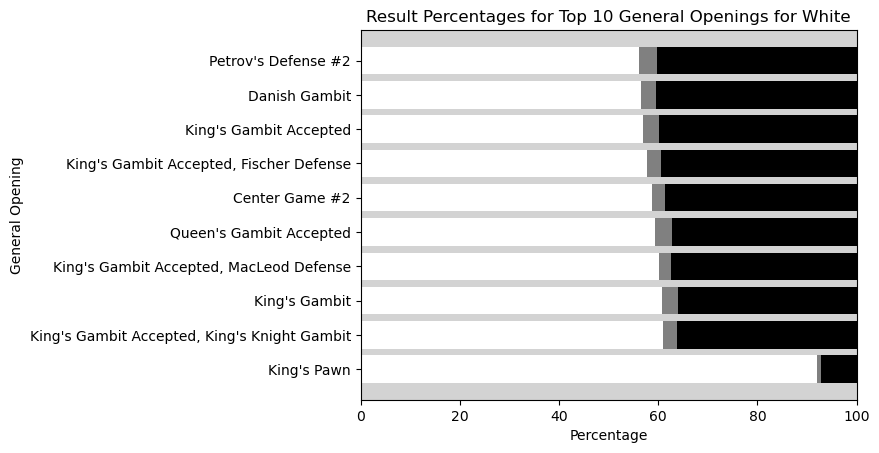

In [43]:
topWhite_df = ratio_df.sort_values(by = "WhiteWinRatio", ascending = False).head(10)

ax = plt.axes()
ax.set_facecolor('lightgray')

b1 = plt.barh(topWhite_df.index, topWhite_df["WhiteWinRatio"] * 100, color = "white")
b2 = plt.barh(topWhite_df.index, topWhite_df["DrawRatio"] * 100, left = topWhite_df["WhiteWinRatio"] * 100, color = "gray")
b3 = plt.barh(topWhite_df.index, topWhite_df["BlackWinRatio"] * 100, left = (topWhite_df["WhiteWinRatio"] + topWhite_df["DrawRatio"]) * 100, color = "black")

plt.title("Result Percentages for Top 10 General Openings for White")
plt.xlabel("Percentage")
plt.ylabel("General Opening")
plt.xlim([0,100])
plt.show()

The next bar chart shows the 10 general openings with the highest wins by black to games played ratios.

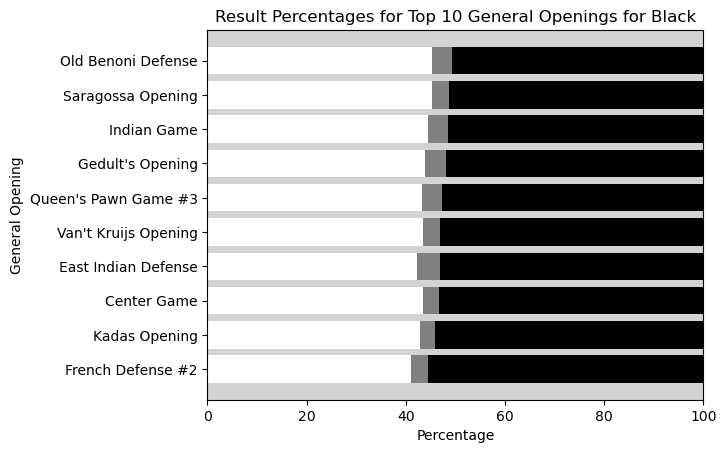

In [44]:
topBlack_df = ratio_df.sort_values(by = "BlackWinRatio", ascending = False).head(10)

ax = plt.axes()
ax.set_facecolor('lightgray')

b1 = plt.barh(topBlack_df.index, topBlack_df["WhiteWinRatio"] * 100, color = "white")
b2 = plt.barh(topBlack_df.index, topBlack_df["DrawRatio"] * 100, left = topBlack_df["WhiteWinRatio"] * 100, color = "gray")
b3 = plt.barh(topBlack_df.index, topBlack_df["BlackWinRatio"] * 100, left = (topBlack_df["WhiteWinRatio"] + topBlack_df["DrawRatio"]) * 100, color = "black")

plt.title("Result Percentages for Top 10 General Openings for Black")
plt.xlabel("Percentage")
plt.ylabel("General Opening")
plt.xlim([0,100])
plt.show()

This bar chart shows the 10 general openings with the highest number of games where the general opening was played. In other words, they are the top 10 most popular or common general openings used. For this bar chart, each general opening is labeled with the number of games they were played in by the number on the right of the bars.

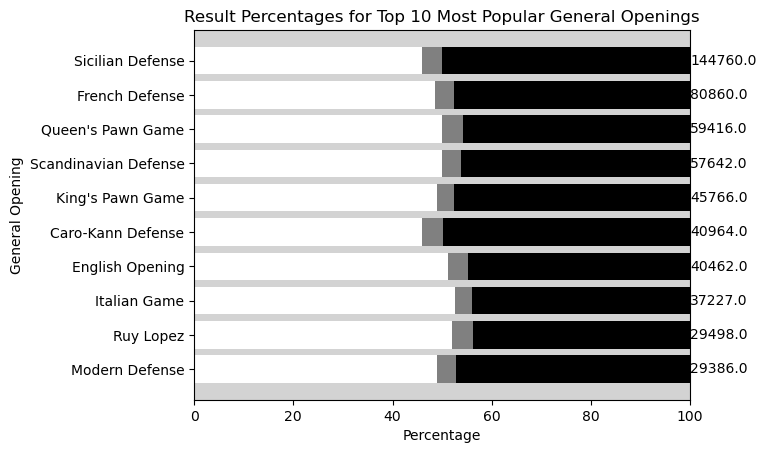

In [45]:
popular_df = ratio_df.sort_values(by = "Games", ascending = False).head(10).sort_values(by = "Games")

ax = plt.axes()
ax.set_facecolor('lightgray')

b1 = plt.barh(popular_df.index, popular_df["WhiteWinRatio"] * 100, color = "white")
b2 = plt.barh(popular_df.index, popular_df["DrawRatio"] * 100, left = popular_df["WhiteWinRatio"] * 100, color = "gray")
b3 = plt.barh(popular_df.index, popular_df["BlackWinRatio"] * 100, left = (popular_df["WhiteWinRatio"] + popular_df["DrawRatio"]) * 100, color = "black")

plt.title("Result Percentages for Top 10 Most Popular General Openings")
plt.xlabel("Percentage")
plt.ylabel("General Opening")
plt.bar_label(b3, popular_df["Games"])
plt.xlim([0,100])
plt.show()